In [1]:
# https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=HMqQTafXEaei

In [2]:
# !nvidia-smi

In [3]:
from transformers import get_linear_schedule_with_warmup, AutoModel, AutoTokenizer
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from collections import defaultdict
from textwrap import wrap
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
import re,os
from os.path import exists

# import emoji
# import nltk
# nltk.download('words')
# words = set(nltk.corpus.words.words())
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


In [4]:
EPOCHS = 32
RANDOM_SEED = 42
MAX_LEN = 128
BATCH_SIZE = 16
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
current_time = datetime.now().strftime("%Y%m%d-%I_%M%p")
outFilepath = 'out/drug_classifier_TweetBERT/' + device.type + current_time +'/'
try:
    os.makedirs(outFilepath)
except FileExistsError:
    pass
outFilepath

'out/drug_classifier_TweetBERT/cuda20230606-12_50PM/'

In [5]:
df1 =pd.read_csv('/data/jmharja/projects/robertaForTweetAnalysis/input/Tweets_Spring_Summer_2021_coded.csv',lineterminator='\n',skipinitialspace=True,)
# df1['label']= 1
# df1.drop(df1.columns[[0, 2,3,4]], axis=1, inplace=True)
df1.shape

(4467, 5)

In [6]:
df1_pos = df1.loc[(df1['Substance'] != 'X') & (df1['Use'] != 'X') & (df1['Intent'] != 'X')]
df1_neg = df1.loc[(df1['Substance'] == 'X') & (df1['Use'] == 'X') & (df1['Intent'] == 'X')]

df1_pos = df1_pos.drop(df1_pos.columns[[0, 2, 3, 4]], axis=1).copy()
df1_neg = df1_neg.drop(df1_neg.columns[[0, 2,3,4]], axis=1).copy()
df1_pos['label']= 1
df1_neg['label']= 0
df1_neg.shape,  df1_pos.shape

((3605, 2), (456, 2))

In [7]:
# prediction result reviewed by Dr. King added for re-training
df2 =pd.read_csv('/data/jmharja/projects/robertaForTweetAnalysis/input/ReviewedPrediction.csv',lineterminator='\n', skipinitialspace=True,)
df2.rename(columns = {'tweet':'Tweet'}, inplace = True)
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]
df2.shape

(821, 4)

In [8]:
df2_pos = df2.loc[(df2['type'] == 1) | (df2['use'] == 1) | (df2['intent'] ==1)]
df2_neg = df2.loc[(df2['type'] != 1) & (df2['use'] != 1) & (df2['intent'] !=1)]
df2_pos = df2_pos.drop(df2_pos.columns[[2,3,1]], axis=1).copy()
df2_neg = df2_neg.drop(df2_neg.columns[[2,3,1]], axis=1).copy()
df2_pos['label']= 1
df2_neg['label']= 0
df2_neg.shape,  df2_pos.shape

((641, 2), (180, 2))

In [9]:
# iteration (predicted result added for re-training)
df3 =pd.read_csv('/data/jmharja/projects/robertaForTweetAnalysis/input/ReviewedPrediction_1.csv',lineterminator='\n', skipinitialspace=True,)
df3_pos= df3.loc[df3['label']==1]
df3_neg = df3.loc[df3['label']==0]
df3_neg.shape, df3_pos.shape

((412, 2), (710, 2))

In [10]:
# # predicted result from 202212 filtered by chatgpt added for retraining
# df4_pos =pd.read_csv('test_result/chatgpt/all_pos.csv',lineterminator='\n', skipinitialspace=True,)
# df4_neg =pd.read_csv('test_result/chatgpt/all_neg.csv',lineterminator='\n', skipinitialspace=True,)
# df4_pos.drop(df4_pos.columns[[0]], axis=1, inplace=True)
# df4_neg.drop(df4_neg.columns[[0]], axis=1, inplace=True)
# df4_pos['label']= 1
# df4_neg['label']= 0
# df4_neg.shape, df4_pos.shape

In [11]:
# df_pos = pd.concat([df1_pos, df2_pos, df3_pos, df4_pos])
# df_neg = pd.concat([df1_neg, df2_neg, df3_neg, df4_neg])
df_pos = pd.concat([df1_pos, df2_pos, df3_pos])
df_neg = pd.concat([df1_neg, df2_neg, df3_neg])
df_neg.shape,  df_pos.shape

((4658, 2), (1346, 2))

In [12]:
# foldername = '400Vs2000'
df1 = df_pos[:1150]
df2 = df_neg[:4575]
df = pd.concat([df1,df2])
df.shape

(5725, 2)

In [13]:
# df2 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2020_01_31_CleanedTweets.csv',
#                 lineterminator='\n',
#                 skipinitialspace=True
#                 )
# df2.drop(df2.columns[[0, 1]], axis=1, inplace=True)
# df2.rename({'text': 'Tweet'}, axis=1, inplace=True)
# df2['label'] = 0
# df4 = df2[1160000:]
# df2 = df2[:800]
# df4 = df4[:200]
# df2.shape, df4.shape

In [14]:
# df_test =pd.read_csv('/users/kent/jmaharja/drugAbuse/finetune/test_new.csv',
# #                    error_bad_lines=False,
#                 lineterminator='\n',
#                 skipinitialspace=True
#                 )
# df_test.drop(df_test.columns[[1, 2, 3]], axis=1, inplace=True)
# # df_test.rename({'text': 'Tweet'}, axis=1, inplace=True)
# # df_test['label']=/ 1
# df_test = df_test.rename(columns={df_test.columns[1]: 'label'})
df_test_neg = df_neg[4575:]
df_test_pos = df_pos[1150:]
df3 = pd.concat([df_test_pos,df_test_neg])
df3.shape

(279, 2)

# DATA PREPROCESSING

In [15]:
# #choosing sequence length
# token_lens = []
# for txt in df.Tweet:
#   tokens = tokenizer.encode(txt)
#   token_lens.append(len(tokens))
# sns.distplot(token_lens)
# plt.xlim([0, 200])
# plt.xlabel('Token count')

# MAX_LEN = 80

In [16]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
class Tweet_DataSet(Dataset):
   def __init__(self, data, tokenizer, max_len):
    self.data = data
    self.data['Tweet'] = self.data['Tweet'].map(lambda x: self.cleaner(x))
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  
   def __len__(self):
    return len(self.data)

   def cleaner(self, tweet):
#         print(tweet)
        tweet = re.sub("@[A-Za-z0-9]+","", tweet) #Remove @ sign
        tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
        tweet = " ".join(tweet.split())
        #     tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
        #     tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
        #     tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
        #          if w.lower() in words or not w.isalpha())
        return tweet
    
        
  
   def __getitem__(self, index:int):
    data_row = self.data.iloc[index]
    tweet = data_row.Tweet
    labels = data_row['label']
    encoding = tokenizer.encode_plus(tweet,
                                     None,
                                     max_length = MAX_LEN,
                                     truncation=True,
                                     pad_to_max_length=True,
                                     add_special_tokens=True,
                                     padding='max_length',
                                     return_token_type_ids=True)

    return {
      'tweet_text': tweet,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(labels, dtype=torch.long)
    }

In [18]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
# df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_test = df3
df_train.shape, df_val.shape, df_test.shape

((5152, 2), (573, 2), (279, 2))

In [19]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Tweet_DataSet(df,tokenizer=tokenizer,max_len=max_len)
  return DataLoader(ds, batch_size=batch_size,num_workers=4)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
class TweetModel(torch.nn.Module):
    def __init__(self):
        super(TweetModel, self).__init__()
        self.bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
        self.drop_out = torch.nn.Dropout(0.5)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = torch.nn.Linear(768, 2)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.bertweet(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.drop_out(pooler)
        output = self.classifier(pooler)
        return output


In [21]:
model = TweetModel()
model = model.to(device)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
#training
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) 
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [23]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
     
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    big_val, big_idx = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(big_idx == targets)

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)

In [24]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)
      outputs = model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids)
      _, preds = torch.max(outputs, dim=1)
      correct_predictions += torch.sum(preds == targets)
      loss = loss_fn(outputs, targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

In [25]:
FORCE_TRAIN = True

print(40*"*", 'Training')
history = defaultdict(list)
best_accuracy = 0
val_acc = 0 

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader,loss_fn, device, len(df_val))
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    curr_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
    torch.save(model.state_dict(), outFilepath +'ckpt.bin')
    best_accuracy = val_acc

**************************************** Training
Epoch 1/32
----------
Train loss 0.28718520915251433 accuracy 0.8969332298136645
Val   loss 0.16426729524715078 accuracy 0.9546247818499127

Epoch 2/32
----------
Train loss 0.15099614352184515 accuracy 0.9565217391304347
Val   loss 0.13978757416932946 accuracy 0.9650959860383944

Epoch 3/32
----------
Train loss 0.12178877242464826 accuracy 0.968555900621118
Val   loss 0.16606259994053593 accuracy 0.9581151832460734

Epoch 4/32
----------
Train loss 0.08915896578518362 accuracy 0.9776785714285714
Val   loss 0.22582708989890912 accuracy 0.9528795811518325

Epoch 5/32
----------
Train loss 0.07259950545972202 accuracy 0.9815605590062111
Val   loss 0.28234567511956105 accuracy 0.9406631762652705

Epoch 6/32
----------
Train loss 0.05403684556660653 accuracy 0.9873835403726707
Val   loss 0.22209179518783154 accuracy 0.9581151832460734

Epoch 7/32
----------
Train loss 0.042838391600616324 accuracy 0.9889363354037266
Val   loss 0.3003738232

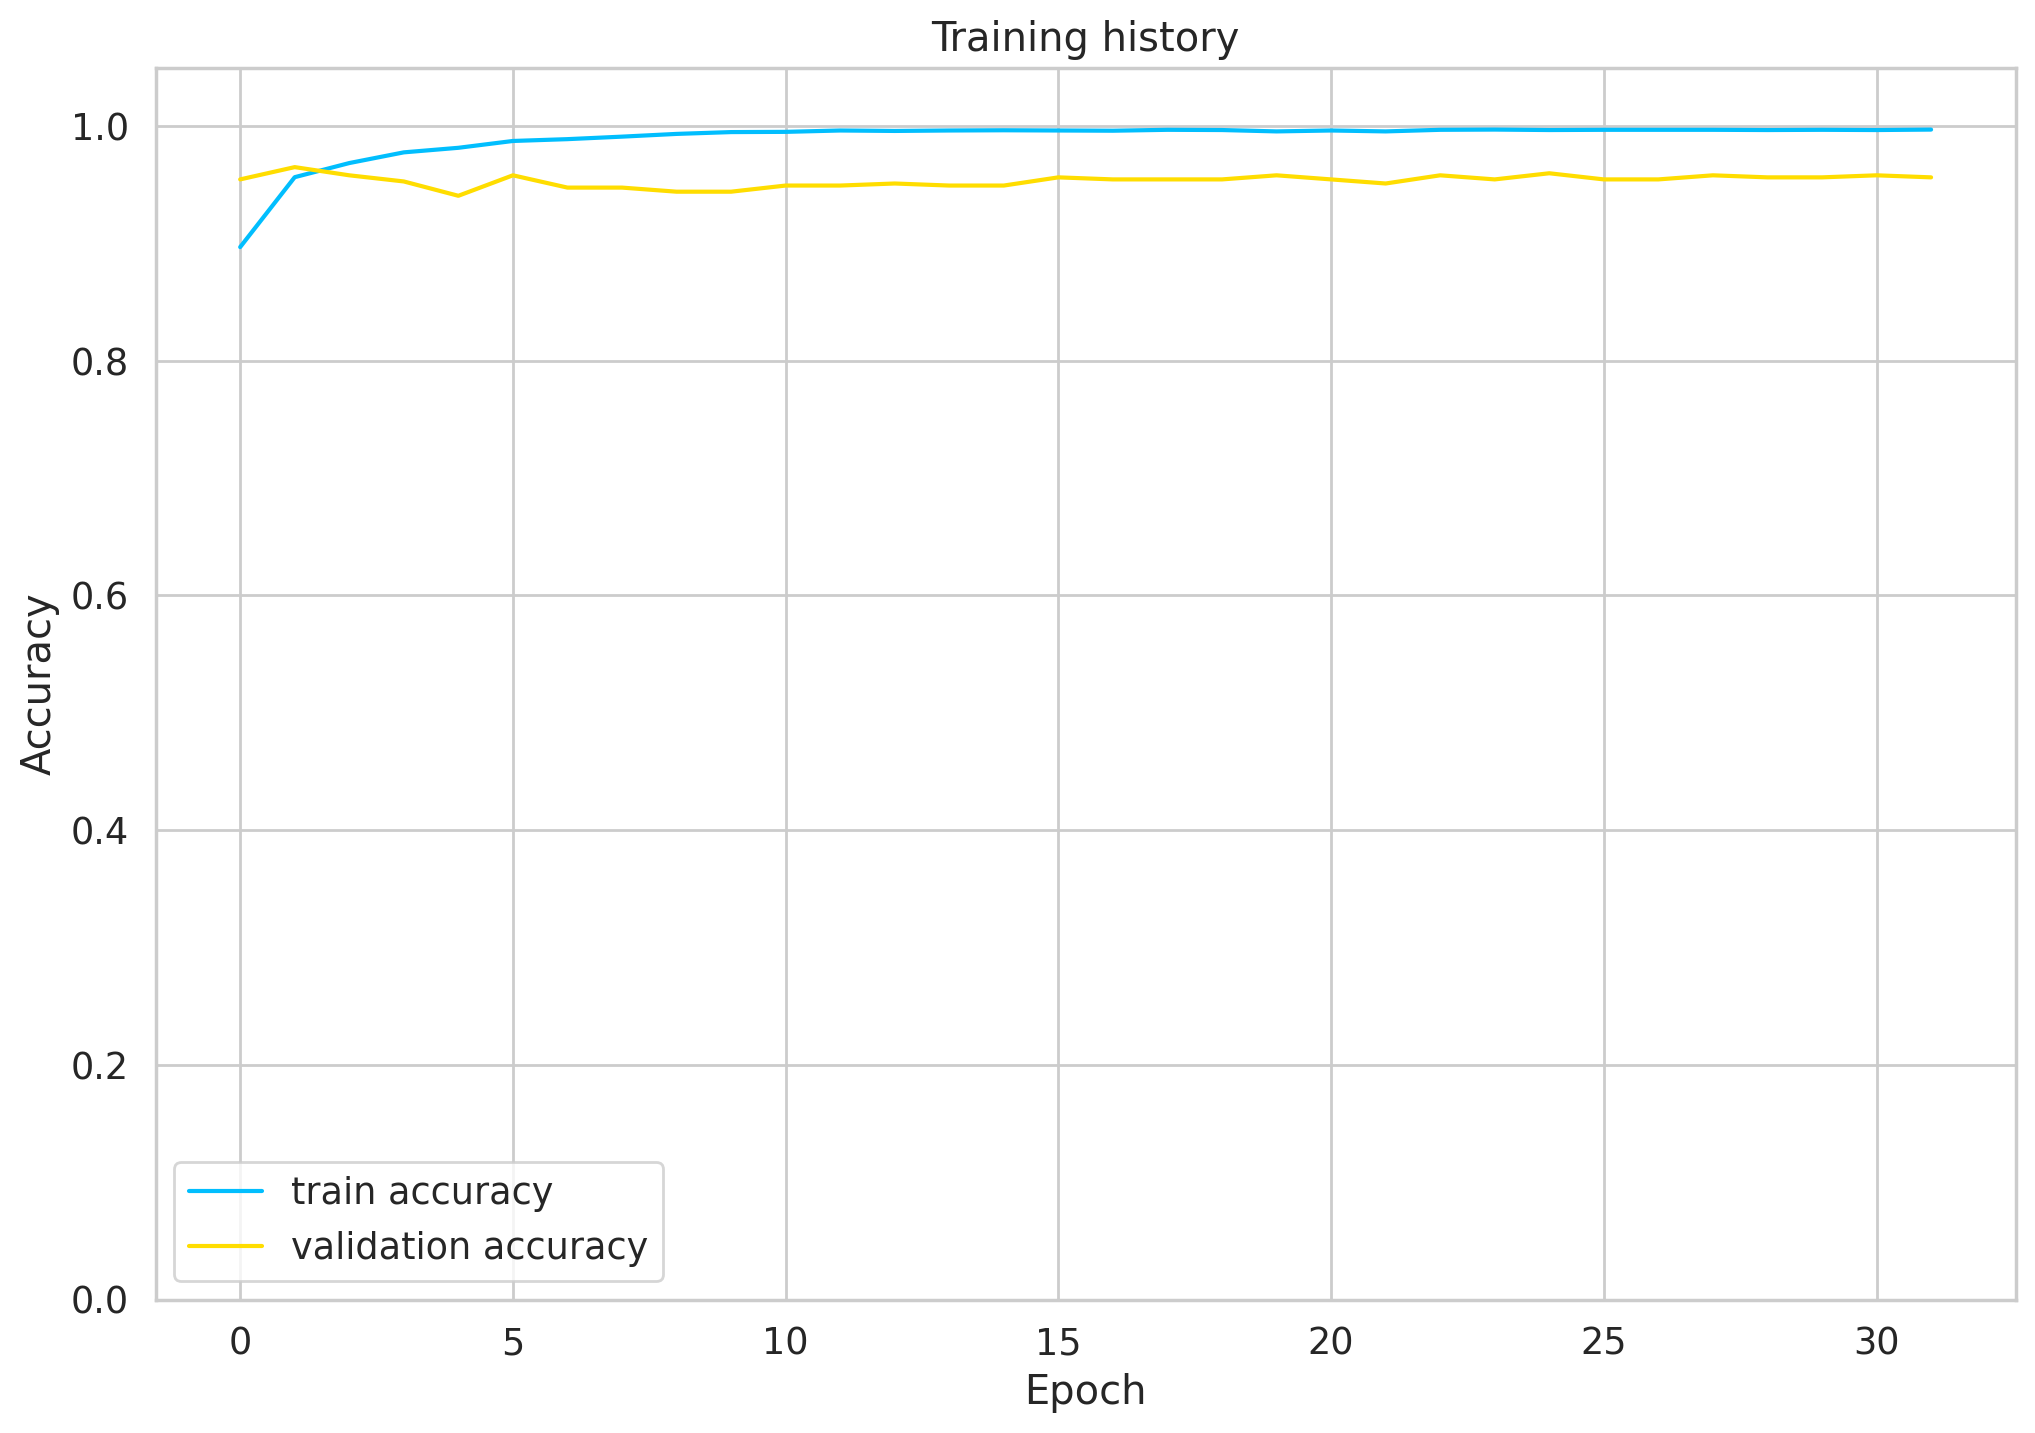

In [48]:
plt.plot([tensor.cpu().numpy() for tensor in history['train_acc']], label='train accuracy')
plt.plot([tensor.cpu().numpy() for tensor in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1.05]);
plt.savefig(outFilepath+'training_hist.png')

In [27]:
# torch.save(model.state_dict(), 'checkpoint/gpu32_best_ftc_model_state_'+ curr_time +'.bin')

In [28]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
test_acc.item()

0.8817204301075269

# PREDICTION


In [29]:
# model.load_state_dict(torch.load('checkpoint/best_ftc_model_state2023_01_17-02_22PM.bin'))

In [30]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      _, preds = torch.max(outputs, dim=1)
      probs = torch.nn.functional.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [31]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, val_data_loader)

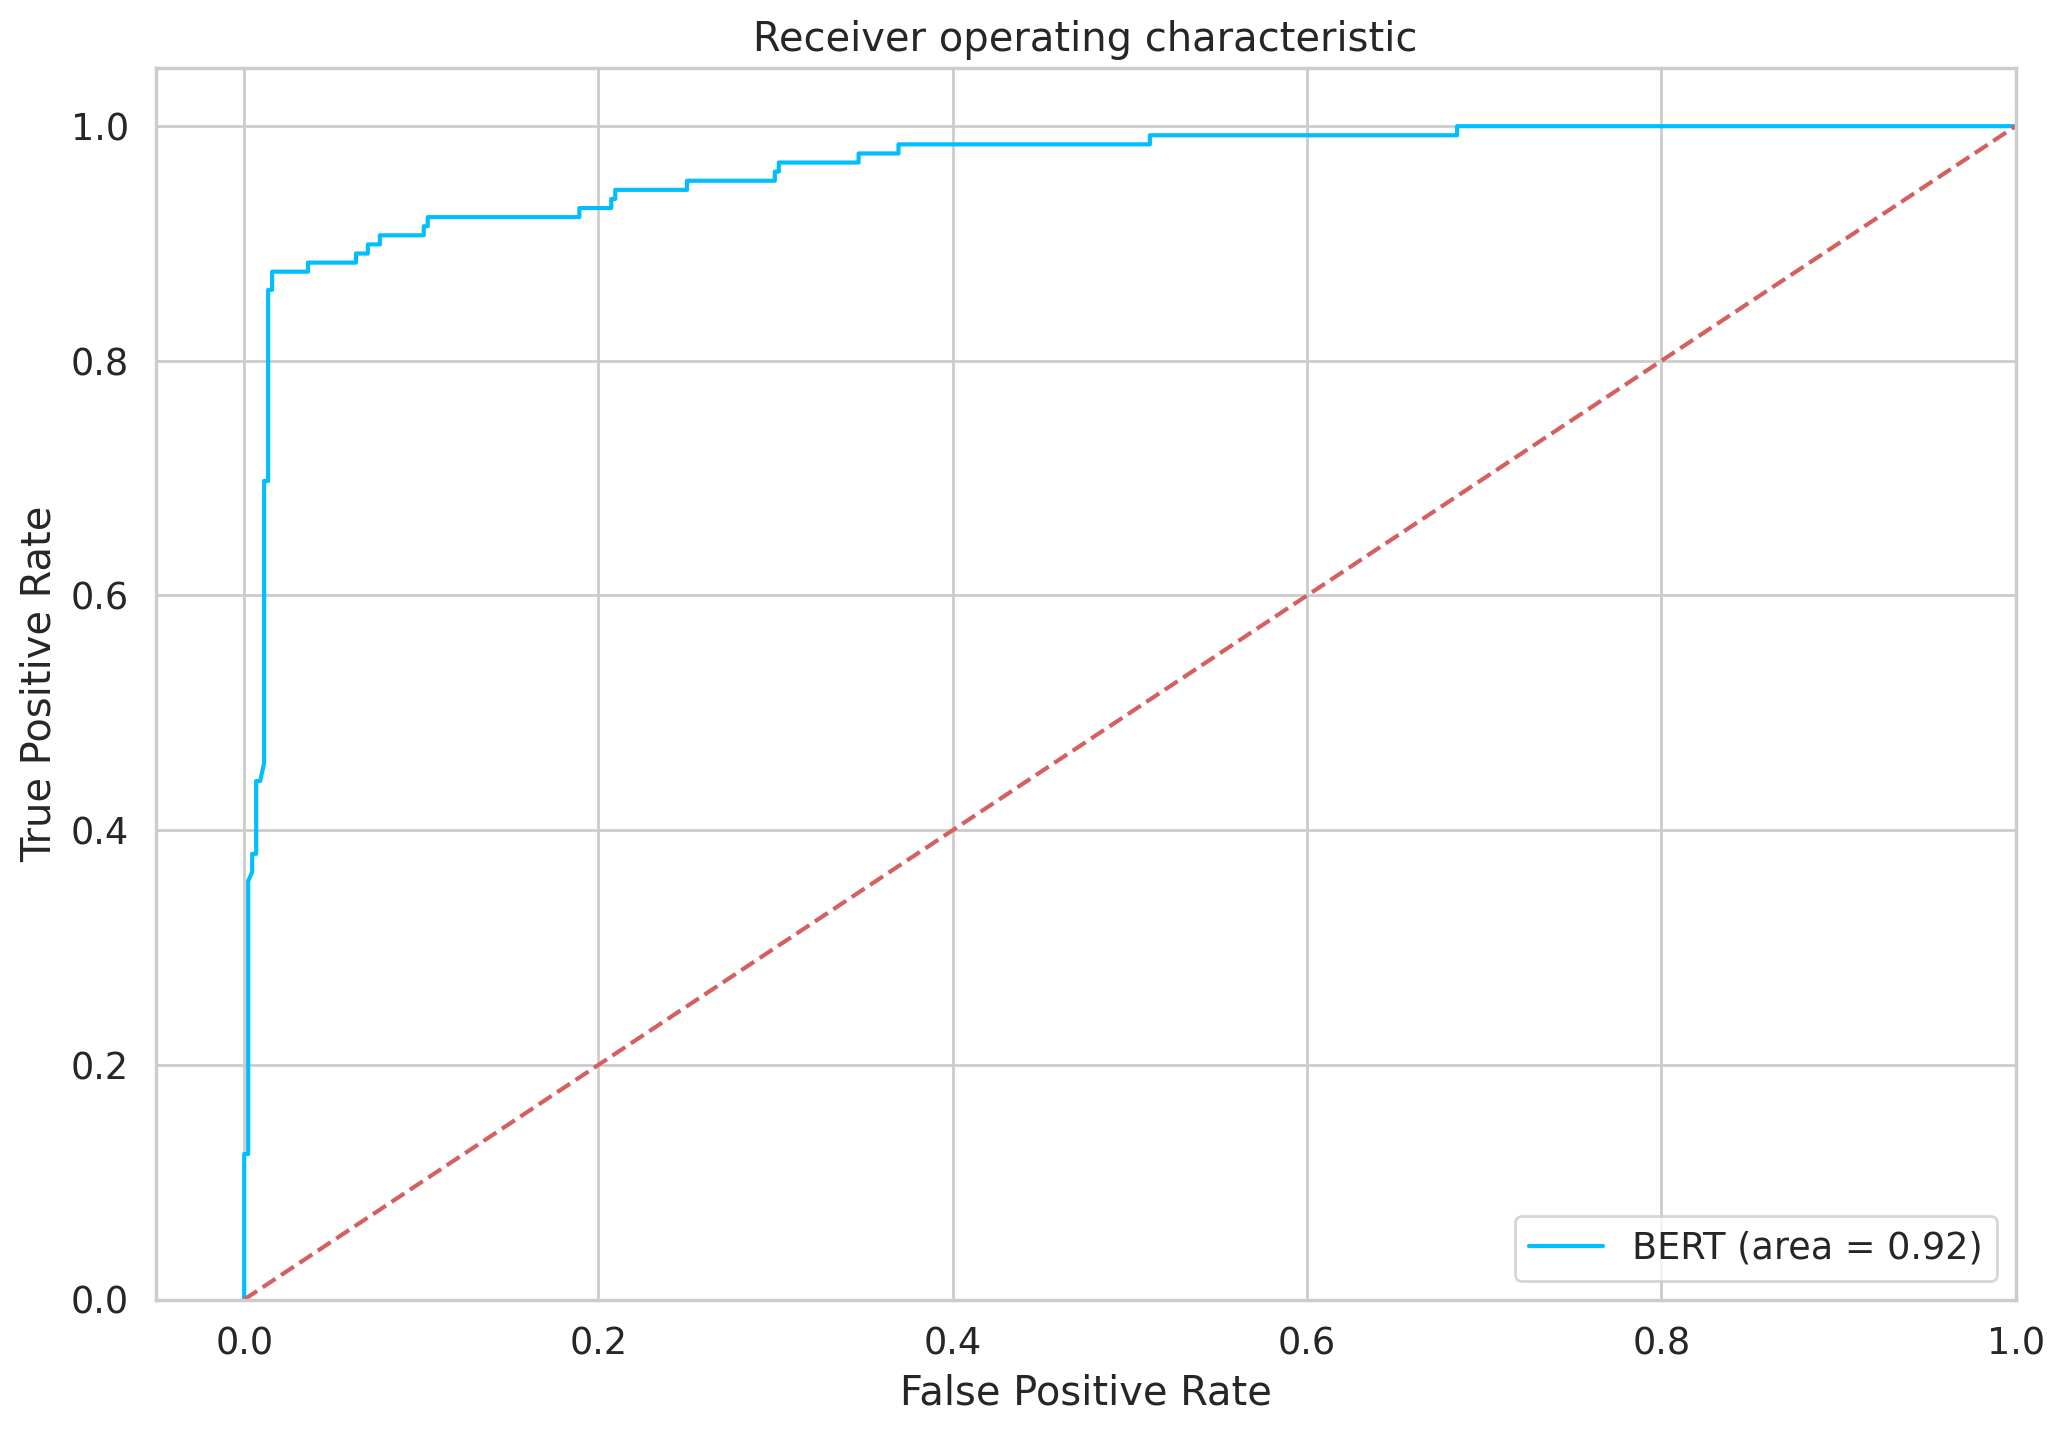

In [32]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred_probs[:, 1].numpy())
plt.figure()
plt.plot(fpr, tpr, label='BERT (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig(outFilepath +'_Log_ROC.png')
plt.show()

In [33]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [34]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_review_texts, y_test.numpy(), y_pred.numpy()))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['Tweet', 'Real', 'Predicted' ])
dff

,readme,Real,Predicted
0,"RT : Roll me like a blunt, because 2020 is her...",1,1
1,RT : drunk af,1,1
2,n e way i’m still kinda drunk but it’s six am ...,1,1
3,RT : New Year ▪ continuing my sobriety drug an...,1,1
4,I tire for guys on here... Any small thing how...,1,1
...,...,...,...
274,RT : scared of losing myself again,0,0
275,RT _: #NewEra_By_SaintRampalJi Don't smoking 🚬...,0,0
276,"RT : If you wanna be a bitch, don’t be a stupi...",0,0
277,RT _duh_nie_luh: this decade is gonna be crazy...,0,1


In [35]:
dff.to_csv( outFilepath + 'test_pred.csv')

In [36]:
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

              precision    recall  f1-score   support

           Y       0.80      0.80      0.80        83
           N       0.91      0.92      0.92       196

    accuracy                           0.88       279
   macro avg       0.86      0.86      0.86       279
weighted avg       0.88      0.88      0.88       279



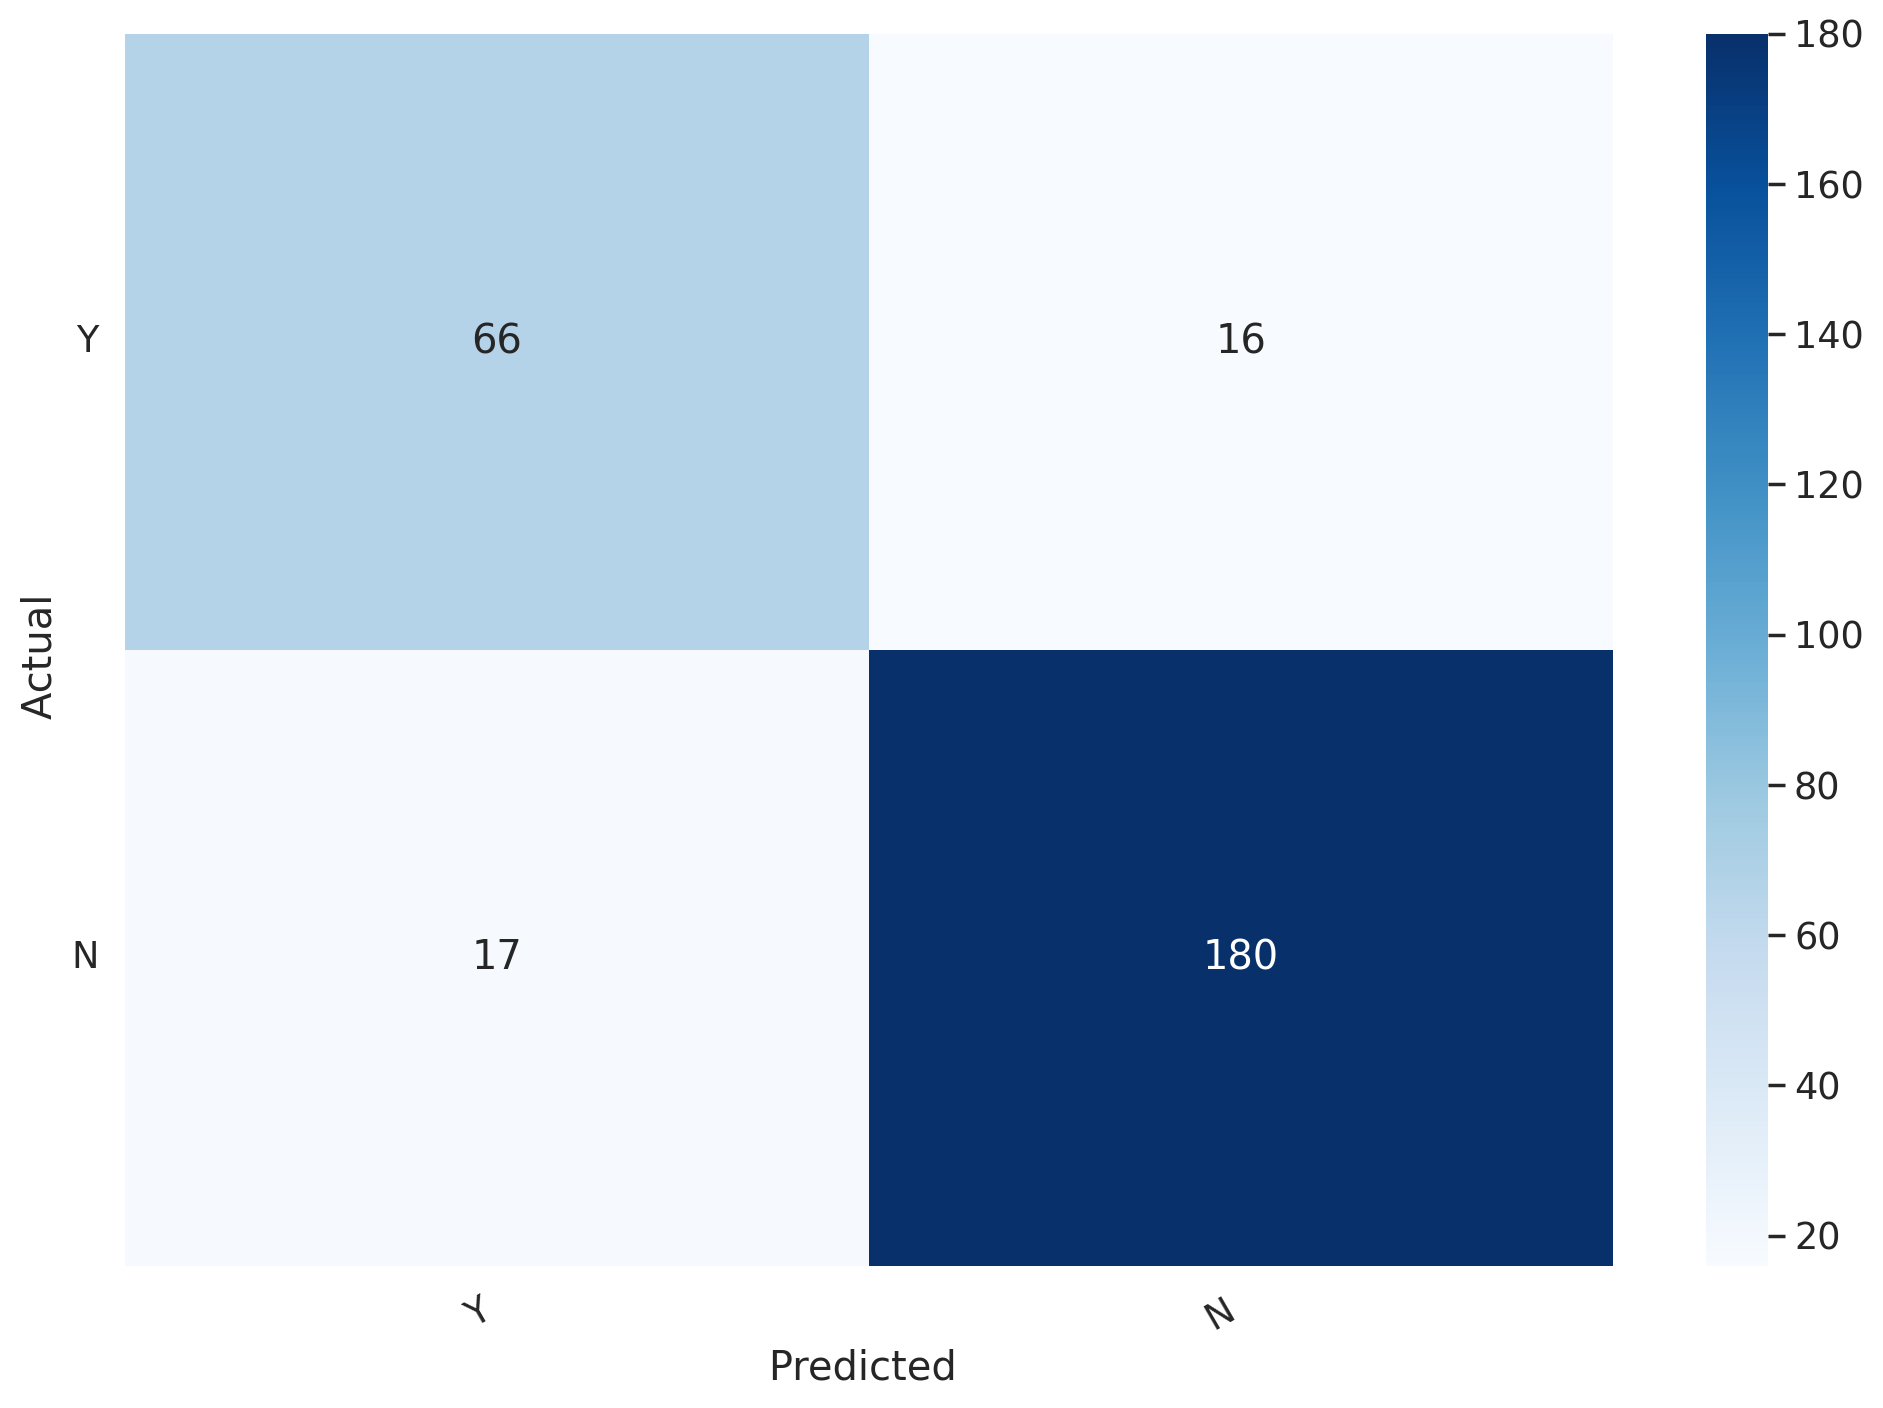

In [37]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Actual ')
  plt.xlabel('Predicted ')
  plt.savefig( outFilepath + 'cm.png')


cm = confusion_matrix(y_pred, y_test)
df_cm = pd.DataFrame(cm, index=['Y', 'N'], columns=['Y', 'N'])
show_confusion_matrix(df_cm)

# PREDICTION ON REAL DATA

In [38]:
df_pred =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2020_01_01.csv',lineterminator='\n',   skipinitialspace=True)
df_pred.drop(df_pred.columns[[0, 1,2, 4]], axis=1, inplace=True)
df_pred = df_pred.rename(columns={df_pred.columns[0]: 'Tweet'})
df_pred['label']= 1

FileNotFoundError: [Errno 2] No such file or directory: '/users/kent/jmaharja/drugAbuse/input/2020_01_01.csv'

In [ ]:
## df_pred =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2022_11.csv',lineterminator='\n',skipinitialspace=True)
# df_pred = pd.read_fwf('/users/kent/jmaharja/drugAbuse/input/2022_11.csv')
# df_pred['label']= 1

In [ ]:
df_pred.shape

In [ ]:
# from sklearn.utils import shuffle
# df_pred = shuffle(df_pred)

In [ ]:
# df_pred = df_pred[:150000]
# df_pred = df_pred[150000:160000]
# df_pred = df_pred[160000:170000]
# df_pred = df_pred[170000:180000]
# df_pred = df_pred[180000:190000]
# df_pred = df_pred[190000:200000]
# df_pred = df_pred[230000:240000]
df_pred= df_pred[250000:260000]
# df_pred = df_pred[1200:2000]

In [ ]:
pred_data_loader = create_data_loader(df_pred, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, pred_data_loader)

In [ ]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_review_texts, y_test.numpy(), y_pred.numpy(), y_pred_probs[:, 1:].numpy().squeeze(), y_pred_probs_pd ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['tweet', 'Real', 'Predicted', 'Pred-prob', 'All Pred-probs' ])
dff

In [ ]:
cm = confusion_matrix(y_pred, y_test)
df_cm = pd.DataFrame(cm, index=['Y', 'N'], columns=['Y', 'N'])
show_confusion_matrix(df_cm)

In [ ]:
dff[dff['Predicted']==1]

In [ ]:
dff[dff['Predicted']==0]

In [ ]:
ones = dff[dff['Predicted']==1]['tweet']
ones.to_csv( outFilepath+'new_test_pred_ones.csv')

In [ ]:
# zeros = dff[dff['Predicted']==0]['tweet']
# zeros.to_csv('test_result/2023_neg.csv')

In [ ]:
dff[[ "tweet", "Predicted"]].to_csv(outFilepath+"new_test_pred.csv)

In [ ]:
current_time

# POST REVIEW

In [ ]:
# ones.tweet.tolist()

# ' '.join(ones['tweet'].tolist())
# ones.tweet.str.cat(sep=', ')

In [50]:
%%capture ''

# Your code goes here

# For example:
print("This is a sample log message.")

# Save the log output to a file
with open("log_file.txt", "w") as f:
    f.write(log_output.stdout)
